# 2. Managing Missing Data

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Having looked at the data in chapter 1, we can see that some variables of interest such as Age are sometimes missing from the ~20% of the dataset. Our exploration also hinted that this information could be a valuable predictor for whether someone survived and so we might be heavily incentivised to use that feature. 

In this chapter, we'll answer three questions that are central to any data analysis:
1. What's missing?
2. Why's it missing?
3. How are we going to handle missing data?

Let's load the data and get started...</span>

In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path.cwd().parent.parent / 'data/titanic/chapter_1'        # Load data
train = pd.read_csv(data_dir / 'train_Ch01.csv')
test = pd.read_csv(data_dir / 'test_Ch01.csv')

print(f"Training data = {train.shape[0]} passengers")
print(f"Test data = {test.shape[0]} passengers")

Training data = 891 passengers
Test data = 418 passengers


## 2.1. What's missing?

<span style="font-size:14px;font-family: Arial;line-height:1.5">
In their book <i>Statistical Analysis with Missing Data</i> (3rd Edition, 2020), Little and Rubin distinguish between the patterns of missing data and the mechanisms of missing data. This distinction highlights that it's important to understand where and when data is missing, but also the reasons why data is absent. 
</span>

### 2.1.1. Which columns have missing data
<span style="font-size:14px;font-family: Arial;line-height:1.5">
For a simple dataset like the titanic files, where each column is supposed to be a distinct measurement, we can start by simply asking which columns have missing data in each dataset. The <span style="color: #ffff00">describe</span> method offers an easy way to do this.
</span>

In [ ]:
# 1: Use the describe method of the dataframe
#   - include='all'     includes both categorical and continuous data
#   - .head(1)          gives us just the counts of non-missing data
train.describe(include='all').head(1)

# To get the number of missing values instead of valid values, use:
train.shape[0] - train.describe(include='all').head(1)

# We could take this further and contrast counts of missing values for train and test data
pd.concat([
    train.shape[0] - train.describe(include='all').head(1).rename({'count':'train'}),    
    test.shape[0] - test.describe(include='all').head(1).rename({'count':'test'})
])

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We have missing rows for <i>Age</i> and <i>Cabin</i> in both test and train data, but we also have rare cases where the port of embarcation (<i>Embarked</i>) is missing from the training data and the <i>Fare</i> paid by one passenger is missing form the test dataset. One can also view the missing Surivival values in the test set as missing data, and thus the entire prediction problem as a kind of imputation.
<br></br>
This pattern of missing data already shapes our approach to predicting test data. Either we ignore Age, Cabin and Fare, or we develop a strategy to deal with missing values. The missing Fare data in particular is a nice illustration of how a test dataset can have properties beyond that shown by the training data.

### 2.1.3. What denotes a missing value - NaN vs. Numbers?

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Here, we're assuming that missing values are coded as NaNs, but that might not always be the case. Sometimes  data acqusition systems will return values out of range or zeros. For example, we saw in Chapter 1.2.4 that some passengers had Fare values of zero, indicating that they did not pay for their tickets.


</span>

 Fortunately such values are easy to identify when you look at the data's distribution, but it's easy to see how any failures to properly investigate and removing such data could dramatically affect subsequent results.
<br></br>
If you're designing a data acquisition system or analysis pipeline, it's normally better to use NaNs than other values (zeros, negative numbers, 99 etc.). NaNs have a clear meaning to other people working with the data, as well as to automated systems that might otherwise interpret numeric data wrongly.

What about the titanic dataset, are there any indications that other codes have been used to denote missing data?


### 2.1.3. Diving deeper into the patterns of missing data

As we'll discuss in the next section, we might have reason to believe that data are missing for a reason - i.e. missing not at random (MNAR). For example, if Age and Cabin data was collected from survivors, then that data would not have been available from those who perished. We can if this is true simply by looking at where the missing data are:

In [ ]:
train.groupby('age_measure')['Survived'].count()

## 2.2. Why is data missing?

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We've highlighted 


Given the similar overlap between age distributions of test and train datasets, it's likely that whatever the cause of missing age data is, it's similar in the two tables.

The reasons for data being missing can be informative and reveal a richer picture of the datasets. This is where being able to do more research into a topic is a useful data science skill. Thinking about the real world, rather than just a data table is critical for gaining extra context to illuminate a topic.

### 2.2.1. Zero Fares: Passengers as Employees

Why would someone pay nothing for a ticket on the most luxurious ship in the world? The obvious first answer is the people who sail the ship, but sailors are not part of the passenger list. Maybe there's something in the data that can shed light on who these passengers might be:
</span>

In [ ]:
(
    pd.concat([
        train[train['Fare'] == 0.0],
        test[test['Fare'] == 0.0]           # test data indicated by Survived=NaN
    ])
    .sort_values(by='Name')
    .filter(['Name','Age','Sex','Pclass','Ticket','n_rooms'])
)

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>If you have background knowledge about the titanic disater, or you've watched the James Cameron film, then some of those names might pop out at you. In particular, <b>Mr Joseph Ismay</b> - a man who paid nothing but had three cabins - what's going on there? Well, he was the managing director of White Star Lines, the company that owned the ship. It's therefore not surprising that he didn't pay to travel, or that he got several rooms. Also listed is <b>Mr Thomas Andrews</b>, the chief designer of the ship and one of the "<b>Titanic Guarentee Group</b>" - a team of 10 engineers sent by the shipbuilders Harland & Wolff to accompany the maiden voyage. Of the 10 in the group, 9 are listed above, while the 10th (Joseph Thompson) disembarked at Southamptom and is not in the dataset.
</p><p>
What about others - could they also be employees? Every individual identified was a man, and given that few women were in the workforce in 1912, it makes it more viable that all these individuals had some relevant profession. Indeed, external research confirms that several men identified above (William Tornquist, William Cahoone Johnson Jr., Alfred Johnson, and Lionel Leonard) were being transported by their employer (<b>American Line</b>). It therefore seems reasonable to summerise that people on zero fares represent a specialty group
</p><p>
Is there value in flagging zero fare passengers? This group has a very low survival rate (1/15) in the training data, suggesting that anyone in the category was very likely to go down with the ship. It may thus be valuable to add a column indicating the special status of zero fare passengers:
</p></span>

In [ ]:
train['zero_fare'] = train['Fare'] == 0
test['zero_fare'] = test['Fare'] == 0

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>The zero values used to mark these passengers may distort the relationship between Fare and Surival, or other variables by reducing the average 
fare of those who did not survive. After adding an identifier for zero payers, we then mask those zero values with the median fare computed from all other passengers in the relevant dataset</p>

In [ ]:
def replace_zeros_with_median(df:pd.DataFrame) -> pd.DataFrame:

    zero_idx = df[df['Fare'] == 0].index
    nonzero_idx = df[df['Fare'] > 0].index

    df.loc[zero_idx,'Fare'] = df.loc[nonzero_idx,'Fare'].median()
    return df

# Replace zeros with median to ameliorate effect of code on statistics
train = replace_zeros_with_median(train)
test = replace_zeros_with_median(test)

# Repeat the log transform from Chapter 1, but now zero values aren't a problem
import numpy as np

train['log_fare'] = np.log(train['Fare'])
test['log_fare'] = np.log(test['Fare'])

### 2.2.2. Missing Age Data
<span style="font-size:14px;font-family: Arial;line-height:1.5">

We noted in Chapter 1.2.1. that age data might be missing because passengers did not surivive. While it is true that the average survival rate is substantially lower in cases where age is missing, there are still 30% of passengers who survive but have no age data. Could these be, for example, children who have lost a parent and don't know their age? Let's find out

</span>


In [ ]:
(
    train.assign(age_missing = lambda x: x['Age'].isna())
    .groupby(['age_missing','Survived'])
    .agg({'Title':['value_counts']})
)

There are very few 'Masters' in the dataset where the age is missing, which makes me think that these individuals are not more likely to be children. I used Master here rather than Miss, in case that title was used for all unmaried women.

## 2.3. Testing if data is missing at random




## 2.4. How are we going to handle missing data?
<span style="font-size:14px;font-family: Arial;line-height:1.5">
several methods for dealing with missing data, either using simple summary statistics or by devising more complex models for predicting missing values based on other features that are available. We'll also cover some statistical models that can handle missing data for you, and what benefits that might offer.

The first thing we'll do is note whether the variable of interest is missing at all, as this can be an important marker that we can use to indicate to ML models that the input data isn't original. 

Note: This chapter is an exploration of some imputation approaches - see also:
 * [sklearn.impute](https://scikit-learn.org/stable/modules/impute.html) 
 * [impyute](https://impyute.readthedocs.io/en/master/)


Credit: The code written below was developed in collaboration with ChatGPT from OpenAI
<span>
### 2.3.1. Preparing the data ahead of imputation
<span style="font-size:14px;font-family: Arial;line-height:1.5">
The fact that data is missing may be interesting itself, and even indicative of the target variable (e.g. if ages of people who died couldn't be recovered). This is particularly the case for features with lots of missing data, such as Age and Class, and so for each of these features, we add a column noting whether the feature is missing or not:</span>

In [ ]:
train['age_missing'] = train['Age'].isna()
test['age_missing'] = test['Age'].isna()

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>Looking ahead to methods of imputation, some approaches such as Regression Imputation, may only take in numeric data. If we want to predict missing data based on categorical information (e.g. predicting Age from Class), we must create numerical values representing each value of the category (e.g. Male=0, Female=1 etc.).
</p>
<p>Note that in the code below, I've used the map method with a specified dictionary of values to make the coding of variables explicit and the numeric values easier to interpret. Mapping in this way also ensures consistency between parallel operations on test and train datasets, while also ensuring that any future values of the source feature that aren't in the map do not receive values. 
</p>
<p>This latter point can be important if we don't know the distribution of feature categories in the test dataset - e.g. if males and females were in the training data, but only females were in the test data and we used a method such as <i>factorize</i>, females would encoded as 1 in the training data, and 0 in the test data. That could be a major bug! (Not that I've ever done that...)
<p></span>

In [ ]:
gender_map = {'male':0,'female':1}
train['gender_numeric'] = train['Sex'].map(gender_map)
test['gender_numeric'] = test['Sex'].map(gender_map)

embark_map = {'C':1,'Q':2,'S':3}
train['embarked_numeric'] = train['Embarked'].map(embark_map)
test['embarked_numeric'] = test['Embarked'].map(embark_map)


### 2.3.2. Methods for replacing missing data


#### 2.3.1.1. Deletion
<span style="font-size:14px;font-family: Arial;line-height:1.5">
This involves simply removing any rows or columns that contain missing data. This method is simple and easy to implement, but it can also reduce the sample size and potentially bias the results if the missing data is not missing completely at random.
<br></br>
Removing observations with missing data also reduces the size of our training set, which could be important in building more sophisticated models in the future. If we're running a business, it might also be very expensive to remove datapoints that we've spent money acquiring. Deletion is therefore also inefficient.
<br></br>
A final problem with deleting data is that it doesn't provide a useful strategy for making predictions on the test set. What happens if we encounter missing data in testing or deployment? If we just delete missing data, then either we can't base predictions a feature that contains missing data (which is highly undesirable) or we have to skip test cases where data is missing (which will hurt performance badly).
<br></br>
For the reasons above, we will avoid removing missing data. The code below simply illustrates how it might be done.
<span>

In [ ]:
# train = train.drop(train.index[train["age_missing"]])
# test = test.drop(test.index[test["age_missing"]])


#### 2.3.2.2. Mean, median or mode imputation
<span style="font-size:14px;font-family: Arial;line-height:1.5">
 This involves replacing the missing data with the mean or median value of the non-missing data in the same column. This can be useful if the missing data is missing at random and if the data is normally distributed. However, it can also distort the distribution of the data and potentially introduce bias if the data is not normally distributed or if the missing data is not missing at random.
<br></br>
 As shown in Chapter 1, most of the input features for the titanic dataset are not normally distributed and so mean imputation is unsuitable for an in-depth analysis. However in the case of Embarked, we have only two missing datapoints and the data type is categorical, that imputation using the most common port of embarcation (i.e. the mode) seems reasonable.</span>
 <br></br>
 <span style="font-size:14px;font-family:Times New Roman;line-height:1.2;color:#aaaaaa">
 Side note: Often people will use mean imputation just to get a solution working, for example in interviews or courses where time is limited. Beyond the biological situations in which most of statistics was developed, the assumption of normality in real-world scenarios rarely met (see Chapter 1.2.1 on Age distribution for an example).</span>

In [ ]:
# Replace with mean 
# train.fillna(train.mean(), inplace=True)
# test.fillna(test.mean(), inplace=True)

# Replace with median 
# train.fillna(train.mean(), inplace=True)
# test.fillna(test.mean(), inplace=True)

# Replace with mode 
most_common_embark = train['Embarked'].mode()[0]
train['Embarked'].fillna(most_common_embark, inplace=True)
# (note there is no missing data for Embark in the test dataset - see Section 2.1.)

#### 2.3.2.3. Resampling

What if the mean, median or mode doesn't provide a good summary of the data? Instead we can randomly sample from the distribution of available values. The limitation of this approach is that each individual estimate is uncertain, although we can use multiple imputation to assess how much of an impact this uncertainty has on our model performance. We'll talk about this more in Section ???)

In [2]:
def replace_by_resampling(df:pd.DataFrame, colname:str, n_impute:int=1) -> pd.DataFrame:
    """ 
        Args:    
            df: dataframe containing variable with missing data
            colname: variable to fill missing data for
            n_impute: number of rounds of imputation
    """

    for impute_count in range(n_impute):

        new_name = f"{colname}_R{impute_count}"
        new_vals = (
            df[colname]
            .dropna()
            .sample(
                n=df[colname].isna().sum(),
                replace=True
            )
        )

        new_vals.index = df[df[colname].isna()].index

        df[new_name] = pd.concat([df[colname].dropna(), new_vals])

    return df

In [3]:
train = replace_by_resampling(train, colname='Age', n_impute=20)
test = replace_by_resampling(test, colname='Age', n_impute=3)

KeyError: "['Age_0', 'Age_1', 'Age_2'] not in index"

#### 2.3.2.4. Stratified Resampling

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We might have good reason to believe that a variable with missing data is dependent on other features in the data. For example if female passengers tended to be older than male passengers. It may therefore be useful to resample data specifically from the most relevant data - i.e. if we have a missing age value for a male passenger, we resample from the available ages for only men. This organization of the dataset is sometimes called *stratification* and can be particularly useful in cases like gender, where there are a small number of possible categories
</span>

In [42]:
from typing import List

def replace_by_stratafied_resampling(df:pd.DataFrame, colname:str, strata:List[str], n_impute:int=1) -> pd.DataFrame:

    # Create the groupby object once to save time
    group_obj = df[strata + [colname]].groupby(strata)

    # For every round of imputation
    for impute_count in range(n_impute):

        # Create new column with original data, including missing data
        new_name = f"{colname}_S{impute_count}"

        # For each stratification layer
        for strate_vals, strata_df in group_obj:

            new_vals = (
                strata_df[colname]
                .dropna()
                .sample(
                    n = strata_df[colname].isna().sum(),
                    replace=True
                )
            )

            new_vals.index = strata_df[strata_df[colname].isna()].index

            df[new_name] = pd.concat([df[colname].dropna(), new_vals])

    return df

In [48]:
train = replace_by_stratafied_resampling(train, colname='Age', strata = ['Sex','Pclass'], n_impute=20) 

#### Comparing the effects of imputation by resampling with and without stratification

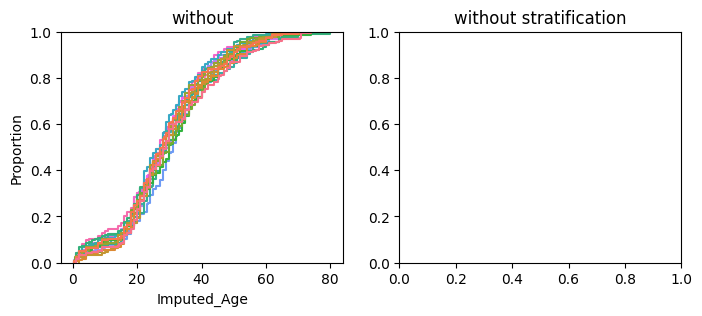

In [47]:
import seaborn as sns

def plot_resampled_distributions(df, cols, ax):

    sns.ecdfplot(
        data = (
            df
            .query('Age.isna()')
            .filter(cols + ['PassengerId'])
            .melt(id_vars=['PassengerId'], value_name='Imputed_Age', var_name='ImputeIdx')
        ),
        x = 'Imputed_Age',
        hue = 'ImputeIdx',
        ax = ax,
        legend = False
    )


import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, **{'figsize':(8,3)})

resamp_cols = [c for c in train.columns if 'Age_R' in c]
plot_resampled_distributions(train, resamp_cols, axs[0])
axs[0].set_title('without')

strat_resamp_cols = [c for c in train.columns if 'Age_S' in c]
plot_resampled_distributions(train, strat_resamp_cols, axs[1])
axs[1].set_title('without stratification')

plt.show()

In [32]:
(
    train
    .query('Age.isna()')
    .filter(resamp_cols + ['PassengerId'])
    .melt(id_vars=['PassengerId'], value_name='Imputed_Age', var_name='ImputeIdx')
    .groupby('ImputeIdx')
    .agg({'Imputed_Age':['std']})
    .mean()
)

Imputed_Age  std    14.541921
dtype: float64

In [31]:
(
    train
    .query('Age.isna()')
    .filter(strat_resamp_cols + ['PassengerId'])
    .melt(id_vars=['PassengerId'], value_name='Imputed_Age', var_name='ImputeIdx')
    .groupby('ImputeIdx')
    .agg({'Imputed_Age':['std']})
    .mean()
)

Imputed_Age  std    12.555602
dtype: float64

#### 2.3.2.4. Regression Imputation

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
This involves using a regression model to predict the missing values based on the non-missing values in the same row or other relevant variables. This can be useful if the missing data is not missing at random and if there is a strong relationship between the missing and non-missing values. However, it can also introduce bias and error if the regression model is misspecified or if there is not a strong relationship between the variables.
</p><p>
In the case of the titanic dataset, we are somewhat limited in the predictors available for imputation. We can get an idea of the relationships between continuous variables by looking at the correlation matrix. Note that here we're considering the factorized version of categorical variables such as gender and class (and class has ordinal implications in that 1st is different from 2nd class in at least the same "direction" as 2nd is different from 3rd class)
</p><p>
If we try to impute values this way, we'll find that a simple regression model does a bad job and predicts impossible values, such as negative ages.
</p></span>

In [ ]:
# train[['Age','SibSp','Fare','PassengerId','gender_numeric','Pclass','Parch']].corr()

In [ ]:
# Define a function that uses the model to make predictions for missing values
# from sklearn.linear_model import LinearRegression

# # Build model from available data
# predictors = ['SibSp','Fare','gender_numeric','Pclass','Parch']

# X = train[predictors].dropna().values
# y = train["Age"].dropna().values

# model = LinearRegression().fit(X, y)

# idx = train[train["age_missing"]].index
# train.loc[idx, "Age"] = model.predict(train.loc[idx, predictors]) 


#### 2.3.2.4. K-Nearest Neighbors Imputation

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
This involves using the values of the k-nearest neighbors to the missing data point to impute the missing value. This can be useful if the data is missing at random and if the missing data is similar to the values of its neighboring points. However, it can also introduce bias and error if the data is not missing at random or if the nearest neighbors are not representative of the missing data point.
</p><p>
These are just a few examples of methods for replacing missing data. There are many other methods and techniques that can be used, and the appropriate method to use depends on the specific context and characteristics of the missing data. It is important to carefully evaluate the missing data and consider the potential implications of different methods before deciding on a course of action.
</p></span>

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 3)

# Select columns to use for impute
columns_for_impute = ['Pclass','SibSp', 'Parch', 'Fare', 'gender_numeric', 'embarked_numeric','Age']

# Fit the imputer to the data
imputer.fit(train[columns_for_impute])

# Transform the data
imputed_data = imputer.transform(train[columns_for_impute])

# Create a new dataframe with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns = columns_for_impute)

#### 2.3.2.5. Neural Networks

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Given the hype, it's important to remember that a neural net isn't magic - it can't find relationships if they don't exist. Also, if those relationships are very complex, we may not have enough data to find them.
</span>

In [ ]:
from tensorflow import keras

# Create a sample dataset with missing values
data = np.array([[1, 2, np.nan],
                 [3, 4, 5],
                 [6, np.nan, 7],
                 [np.nan, 8, 9]])

# Define the model
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(3,)),
    keras.layers.Dense(10),
    keras.layers.Dense(3)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(data, data, epochs=100)

# Use the trained model to impute missing values
imputed_data = model.predict(data)

# Print the imputed dataset
print(imputed_data)

## 2.4. Further Considerations

### 2.4.1. Documenting Missing Data

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We began this chapter by discussing how to find missing data and think about the reasons why some datapoints might be absent. While the titanic dataset is useful for illustrating the general flow of data science workflows, it should be noted that it's best practice to document the sources and reasons for missing data at the point of data collection. 

</span>


### 2.4.2. Approaches that are robust to missing data

- Generalized linear mixed models
- XGBoost (Sparsity Aware Split Finding)

### 2.4.3. Preventing Data Leakage: Never merge the train and test data

<span style="font-size:14px;font-family: Arial;line-height:1.5">

When imputing missing data, one might think that we should combine data from the training and test datasets, so that we can maximise our ability to estimate missing values. However, if we were to merge the two datasets, we would potentially risk **data leakage** that might undermine the model we're training. 

A simple example using regression imputation shows you why: Here we simulate a simple experiment in which age is correlated with ticket fare, but the correlation coefficients and ranges of fares in test and train data are different:

</span>

In [ ]:
import numpy as np

n_passengers, max_age = 200, 80

train_age = np.random.rand(n_passengers) * max_age
test_age = np.random.rand(n_passengers) * (max_age/2)              # test subjects are half as old 

train_fare = (train_age * 10) + (25*np.random.rand(n_passengers))   # y = a + bx + noise
test_fare = (test_age * 5) + (25*np.random.rand(n_passengers))      

# mask a subset of ages (data has no order)
proportion_missing = 0.3
train_age[:int(n_passengers*proportion_missing)] = np.nan   
fares_for_missing_data = train_fare[:int(n_passengers*proportion_missing)]

In [ ]:
# Impute values using linear regression with only training data
from sklearn.linear_model import LinearRegression

X = train_fare[~np.isnan(train_age)].reshape(-1,1)
y = train_age[~np.isnan(train_age)].reshape(-1,1)

training_only = LinearRegression().fit(X, y)
trained_only_prediction = training_only.predict(fares_for_missing_data.reshape(-1, 1))

In [ ]:
# Now impute values using linear regression on merged test and training data
X_merged = np.vstack((X, test_fare.reshape(-1, 1)))
y_merged = np.vstack((y, test_age.reshape(-1, 1)))

merged_model = LinearRegression().fit(X_merged, y_merged)
merged_prediction = merged_model.predict(fares_for_missing_data.reshape(-1,1))

<span style="font-size:14px;font-family: Arial;line-height:1.5">
When we plot the results in the cell below, we can see that the imputed ages of subjects is very strongly affected by the merging of train and test datasets. If we were then to build our survival model based on the ages imputed after merging, that model would also be influenced by the test data. In deployment, such a model may generalize poorly because it can no longer rely on the leaked information that allowed it to perform well on the test data.
</span>

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.scatter(train_fare, train_age, marker='.', color='c', alpha=0.5, label='Train (Observed)')
plt.scatter(test_fare, test_age, marker='.', color='orange', alpha=0.5, label='Test (Observed)')

plt.scatter(
    train_fare[np.isnan(train_age)], 
    trained_only_prediction, 
    marker='x', s=5, color='b', label='Train (Imputed)')

plt.scatter(
    train_fare[np.isnan(train_age)], 
    merged_prediction, 
    marker='x', s=5, color='r', label='Merged (Imputed)')

plt.ylabel('Age (Years)')
plt.xlabel('Fare (£)')
plt.legend()
plt.show()



### 2.4.2. Multiple Imputation

(Credit: Sklearn.Impute Documentation)

In the statistics community, it is common practice to perform multiple imputations, generating, for example, *m* separate imputations for a single feature matrix. Each of these *m* imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The *m* final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. 

## Conclusions

Note that imputing missing data is not always a valid approach - particularly in research science, where the primacy of data is critical (and single data points can cost thousands of dollars to obtain). Here, it may be better to have no data and be clear that the absence exists than it is to fill in missing data based on assumptions or estimates that are ultimately based on the prejudice of the investigator.

However, i